In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pymorphy3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv("datasets/banks.csv", sep ="\t")

In [3]:
stop = stopwords.words("russian")
morph = pymorphy3.MorphAnalyzer()

def preproc(text):
        
        tokenized = RegexpTokenizer(r'\w+').tokenize(text)

        lemmatized = [morph.parse(word)[0].normal_form for word in tokenized]

        words_filtered = [word for word in lemmatized if word not in stop]
        return words_filtered

In [4]:
data["Text_p"] = data["Text"].apply(preproc)

def pos(text):
    if text == "Positive":
        return 1
    else:
        return 0

data["Positive"] = data["Score"].apply(pos)

In [5]:
X = data["Text"]
y = data["Positive"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=70)

In [6]:
v = CountVectorizer()
X_train_v = v.fit_transform(X_train.values)

In [7]:
model = MultinomialNB()
model.fit(X_train_v, y_train)

MultinomialNB()

In [8]:
X_test_v = v.transform(X_test.values)
model.score(X_test_v, y_test)

0.9374285714285714

In [9]:
v = CountVectorizer()
def vect_func (list):
    return v.fit_transform(list)

# list(gensim.downloader.info()["models"].keys())


with neural network
(tokenization already done)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [11]:
print ("cuda is available: ", torch.cuda.is_available())
print ("using cpu")
device = torch.device("cpu")

cuda is available:  False
using cpu


In [12]:
index2word = []

for sent in data["Text_p"]:   
    for token in sent:
        if token not in index2word:
                index2word.append(token)


In [13]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [14]:
def encode(text):
    return [word2index[word] for word in text]

In [15]:
data["Text_e"] = data["Text_p"].apply(encode)

<Axes: ylabel='Text_l'>

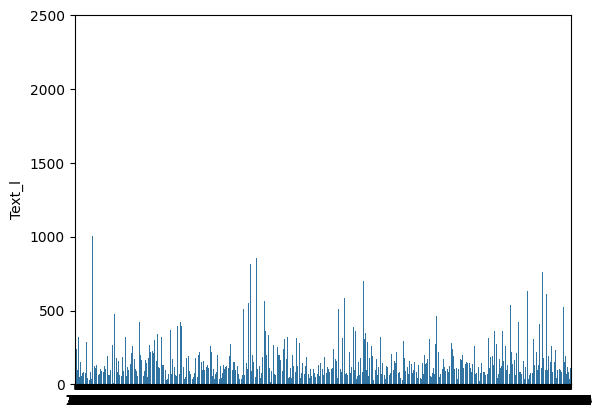

In [16]:
data["Text_l"] = data["Text_p"].apply(lambda x: len(x))
sns.barplot(data["Text_l"])

In [17]:
def padding(sentence):
    if len(sentence) >=300:
        return sentence[0:300]
    else:
        return (sentence + list(np.zeros(300 - len(sentence))))

In [18]:
data["Text_prep"] = data["Text_e"].apply(padding)

In [19]:
batch_size = 50

X_nn = data["Text_prep"]
y_nn = data["Positive"]

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.25, random_state=70)

train_nn = TensorDataset(torch.LongTensor(list(X_train_nn.values)), torch.LongTensor(list(y_train_nn.values)))
test_nn = TensorDataset(torch.LongTensor(list(X_test_nn.values)), torch.LongTensor(list(y_test_nn.values)))

train_nnd = DataLoader(train_nn, shuffle=True, batch_size=batch_size, drop_last=True)
test_nnd =  DataLoader(test_nn, shuffle=True, batch_size=batch_size, drop_last=True)

In [20]:
a = [1,2,3]
b = torch.IntTensor(a)
print(b[0])


tensor(1, dtype=torch.int32)


In [21]:
class LSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim, 3)
    
    def forward(self, x, hidden):
        embs = self.embedding(x)

        out, hidden = self.lstm(embs, hidden)

        out = self.dropout(out)

        out = self.fc(out)

        out = out[:, -1]

        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [22]:
model = LSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

c:\Users\1\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_nnd):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

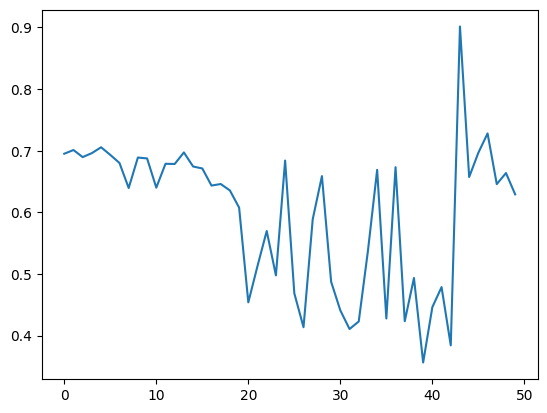

In [25]:
plt.plot(losses)

In [26]:
# Expected tensor for argument #1 'indices' to have one of the following scalar types:
# Long, Int; but got torch.DoubleTensor instead (while checking arguments for embedding)